# 肺炎胸部X光图像异常检测与模型解释

## 项目概述
本项目完成以下任务：
1. 数据预处理
2. 训练3个ML/DL模型并评估（使用F1分数）
3. 实现第一种XAI方法（GradCAM）
4. 撰写第一份XAI解释
5. 实现第二种XAI方法（LIME）
6. 撰写第二份XAI解释



## Task 1: 数据预处理

### 1.1 导入必要的库



In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")



Libraries imported successfully!
PyTorch version: 2.8.0+cu128
CUDA available: True


### 1.2 加载图像数据



In [6]:
# 数据路径
data_dir = '/root/autodl-tmp/data'

def load_images_from_folder(folder_path, label):
    """从文件夹加载图像和标签"""
    images = []
    labels = []
    file_paths = []
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(label)
                file_paths.append(img_path)
            except Exception as e:
                print(f"Failed to load image {img_path}: {e}")
    
    return images, labels, file_paths

# 加载训练集
train_normal_images, train_normal_labels, _ = load_images_from_folder(
    os.path.join(data_dir, 'train', 'NORMAL'), 0)
train_pneumonia_images, train_pneumonia_labels, _ = load_images_from_folder(
    os.path.join(data_dir, 'train', 'PNEUMONIA'), 1)

# 加载测试集
test_normal_images, test_normal_labels, _ = load_images_from_folder(
    os.path.join(data_dir, 'test', 'NORMAL'), 0)
test_pneumonia_images, test_pneumonia_labels, _ = load_images_from_folder(
    os.path.join(data_dir, 'test', 'PNEUMONIA'), 1)

# 加载验证集
val_normal_images, val_normal_labels, _ = load_images_from_folder(
    os.path.join(data_dir, 'val', 'NORMAL'), 0)
val_pneumonia_images, val_pneumonia_labels, _ = load_images_from_folder(
    os.path.join(data_dir, 'val', 'PNEUMONIA'), 1)

# 合并数据
train_images = train_normal_images + train_pneumonia_images
train_labels = train_normal_labels + train_pneumonia_labels

test_images = test_normal_images + test_pneumonia_images
test_labels = test_normal_labels + test_pneumonia_labels

val_images = val_normal_images + val_pneumonia_images
val_labels = val_normal_labels + val_pneumonia_labels

print(f"Training set: {len(train_images)} images (NORMAL: {train_labels.count(0)}, PNEUMONIA: {train_labels.count(1)})")
print(f"Test set: {len(test_images)} images (NORMAL: {test_labels.count(0)}, PNEUMONIA: {test_labels.count(1)})")
print(f"Validation set: {len(val_images)} images (NORMAL: {val_labels.count(0)}, PNEUMONIA: {val_labels.count(1)})")



Training set: 5216 images (NORMAL: 1341, PNEUMONIA: 3875)
Test set: 624 images (NORMAL: 234, PNEUMONIA: 390)
Validation set: 16 images (NORMAL: 8, PNEUMONIA: 8)


### 1.3 可视化样本图像



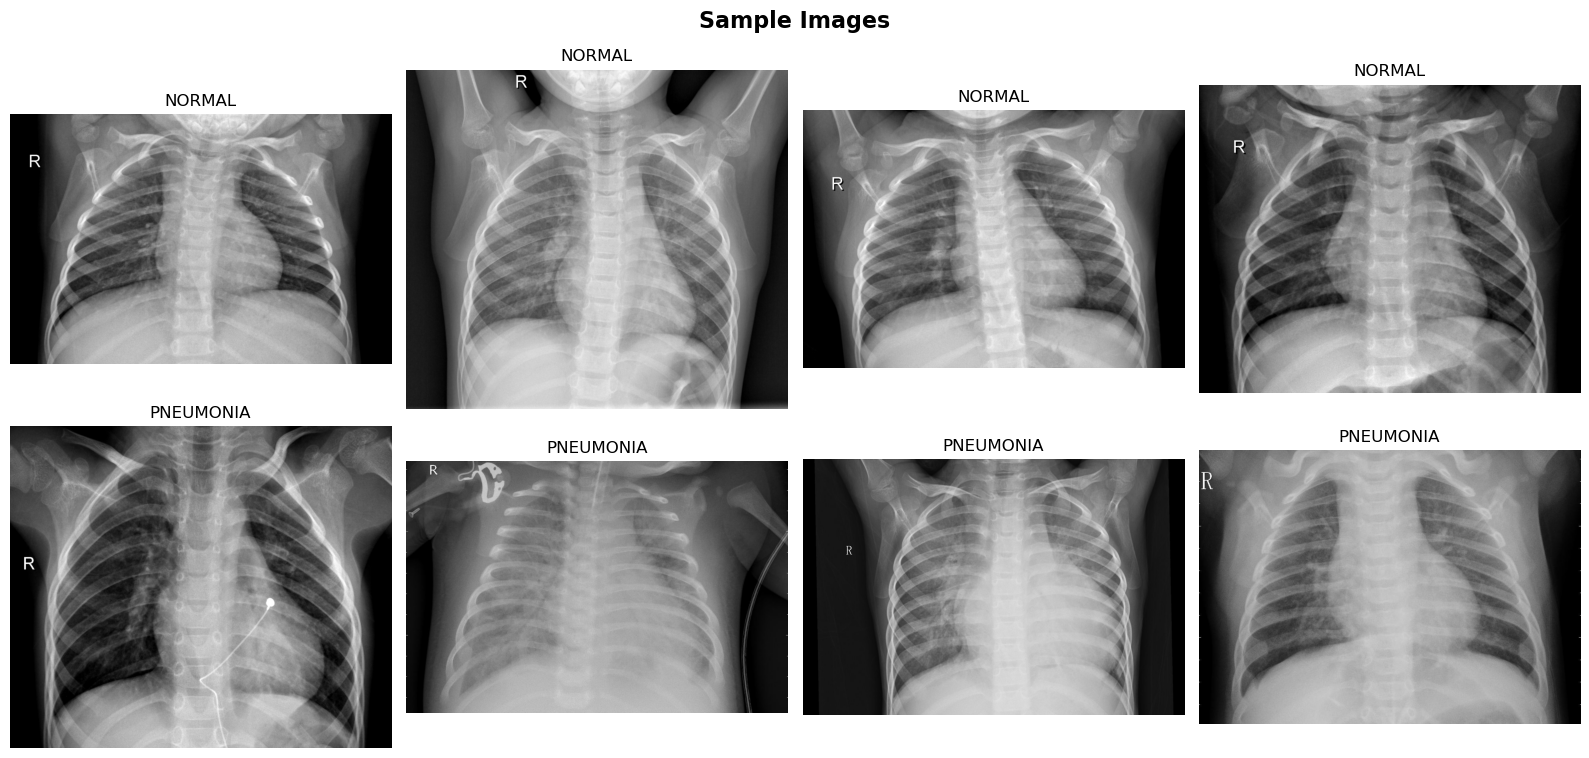

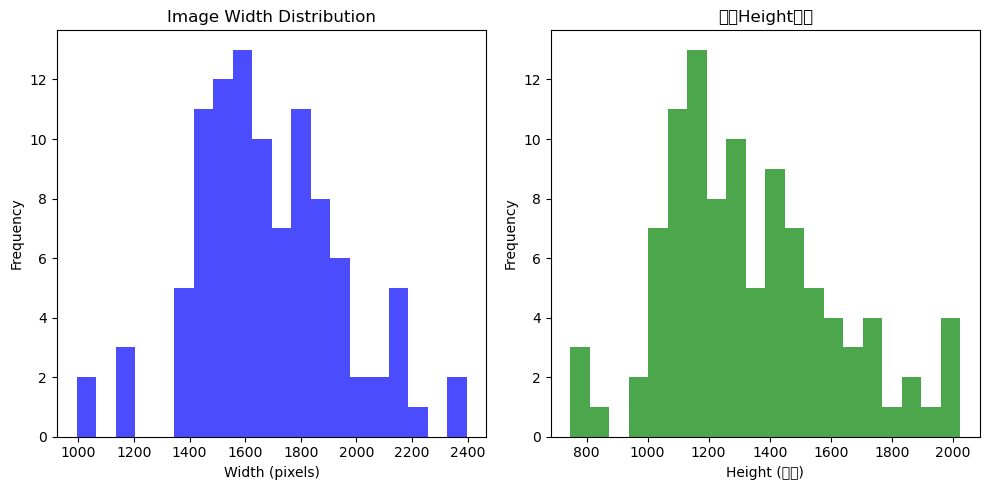

Image size range: Width 994-2396, Height 747-2025


In [7]:
# 可视化样本图像
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Images', fontsize=16, fontweight='bold')

# 显示NORMAL样本
normal_samples = [img for img, label in zip(train_images, train_labels) if label == 0][:4]
for i, img in enumerate(normal_samples):
    axes[0, i].imshow(img)
    axes[0, i].set_title('NORMAL', fontsize=12)
    axes[0, i].axis('off')

# 显示PNEUMONIA样本
pneumonia_samples = [img for img, label in zip(train_images, train_labels) if label == 1][:4]
for i, img in enumerate(pneumonia_samples):
    axes[1, i].imshow(img)
    axes[1, i].set_title('PNEUMONIA', fontsize=12)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('results/figures/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

# 显示图像尺寸分布
image_sizes = [img.size for img in train_images[:100]]  # 采样查看
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, alpha=0.7, color='blue')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.title('Image Width Distribution')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, alpha=0.7, color='green')
plt.xlabel('Height (像素)')
plt.ylabel('Frequency')
plt.title('图像Height分布')

plt.tight_layout()
plt.savefig('results/figures/image_size_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Image size range: Width {min(widths)}-{max(widths)}, Height {min(heights)}-{max(heights)}")



### 1.4 数据预处理：缩放和归一化



In [8]:
# 定义图像预处理：统一尺寸和归一化
IMG_SIZE = 224  # 统一图像尺寸

def preprocess_images(images, labels):
    """预处理图像：调整大小并转换为numpy数组"""
    processed_images = []
    processed_labels = []
    
    for img, label in zip(images, labels):
        # 调整大小
        img_resized = img.resize((IMG_SIZE, IMG_SIZE))
        # 转换为numpy数组并归一化到[0,1]
        img_array = np.array(img_resized, dtype=np.float32) / 255.0
        processed_images.append(img_array)
        processed_labels.append(label)
    
    return np.array(processed_images), np.array(processed_labels)

# 预处理所有数据集
print("Preprocessing training set...")
X_train, y_train = preprocess_images(train_images, train_labels)

print("Preprocessing test set...")
X_test, y_test = preprocess_images(test_images, test_labels)

print("Preprocessing validation set...")
X_val, y_val = preprocess_images(val_images, val_labels)

print(f"\nPreprocessing completed!")
print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Validation set shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")



Preprocessing training set...
Preprocessing test set...
Preprocessing validation set...

Preprocessing completed!
Training set shape: (5216, 224, 224, 3), Labels shape: (5216,)
Test set shape: (624, 224, 224, 3), Labels shape: (624,)
Validation set shape: (16, 224, 224, 3), Labels shape: (16,)
Pixel value range: [0.000, 1.000]


## Task 2: 模型训练与评估

### 2.1 模型1: 随机森林（传统机器学习）



In [9]:
# 为传统ML模型提取特征（使用HOG特征或简单的像素特征）
from skimage.feature import hog
from skimage import exposure

def extract_hog_features(images, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    """提取HOG特征"""
    features = []
    for img in images:
        # 转换为灰度图
        if len(img.shape) == 3:
            gray = np.mean(img, axis=2)
        else:
            gray = img
        
        # 提取HOG特征
        hog_feat = hog(gray, pixels_per_cell=pixels_per_cell, 
                      cells_per_block=cells_per_block, 
                      visualize=False, feature_vector=True)
        features.append(hog_feat)
    return np.array(features)

# 提取特征（使用采样以加快速度）
print("Extracting HOG features...")
sample_size = min(2000, len(X_train))  # 采样训练
train_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train[train_indices]
y_train_sample = y_train[train_indices]

X_train_hog = extract_hog_features(X_train_sample)
X_test_hog = extract_hog_features(X_test)

print(f"HOG feature dimension: {X_train_hog.shape[1]}")

# 训练随机森林模型
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_hog, y_train_sample)

# Pred
y_train_pred_rf = rf_model.predict(X_train_hog)
y_test_pred_rf = rf_model.predict(X_test_hog)

# 评估
train_f1_rf = f1_score(y_train_sample, y_train_pred_rf)
test_f1_rf = f1_score(y_test, y_test_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
test_prec_rf = precision_score(y_test, y_test_pred_rf)
test_rec_rf = recall_score(y_test, y_test_pred_rf)

print(f"\nRandom Forest Model Performance:")
print(f"Training F1 Score: {train_f1_rf:.4f}")
print(f"Test F1 Score: {test_f1_rf:.4f}")
print(f"Test Accuracy: {test_acc_rf:.4f}")
print(f"Test Precision: {test_prec_rf:.4f}")
print(f"Test Recall: {test_rec_rf:.4f}")

# 保存结果
results_rf = {
    'model': 'Random Forest',
    'train_f1': train_f1_rf,
    'test_f1': test_f1_rf,
    'test_acc': test_acc_rf,
    'test_prec': test_prec_rf,
    'test_rec': test_rec_rf
}



Extracting HOG features...
HOG feature dimension: 6084

Training Random Forest model...

Random Forest Model Performance:
Training F1 Score: 1.0000
Test F1 Score: 0.8304
Test Accuracy: 0.7500
Test Precision: 0.7208
Test Recall: 0.9795


### 2.2 模型2: 简单CNN（深度学习模型1）



In [10]:
# 定义简单CNN模型
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.relu5 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 创建PyTorch数据集
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # 转换为CHW格式
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        
        image = torch.FloatTensor(image)
        label = torch.LongTensor([label])[0]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 准备数据加载器
train_dataset = ImageDataset(X_train, y_train)
test_dataset = ImageDataset(X_test, y_test)
val_dataset = ImageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

simple_cnn = SimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("\nStarting Simple CNN model training...")
for epoch in range(num_epochs):
    # 训练阶段
    simple_cnn.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = simple_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # 验证阶段
    simple_cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = simple_cnn(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# 在测试集上评估
simple_cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = simple_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_f1_cnn = f1_score(all_labels, all_preds)
test_acc_cnn = accuracy_score(all_labels, all_preds)
test_prec_cnn = precision_score(all_labels, all_preds)
test_rec_cnn = recall_score(all_labels, all_preds)

print(f"\nSimple CNN Model Performance:")
print(f"Test F1 Score: {test_f1_cnn:.4f}")
print(f"Test Accuracy: {test_acc_cnn:.4f}")
print(f"Test Precision: {test_prec_cnn:.4f}")
print(f"Test Recall: {test_rec_cnn:.4f}")

# 保存模型
torch.save(simple_cnn.state_dict(), 'results/models/simple_cnn.pth')

results_cnn = {
    'model': 'Simple CNN',
    'test_f1': test_f1_cnn,
    'test_acc': test_acc_cnn,
    'test_prec': test_prec_cnn,
    'test_rec': test_rec_cnn,
    'train_losses': train_losses,
    'val_losses': val_losses
}



Using device: cuda

Starting Simple CNN model training...
Epoch [1/10], Train Loss: 0.3044, Train Acc: 0.8760, Val Loss: 0.6034, Val Acc: 0.6875
Epoch [2/10], Train Loss: 0.1145, Train Acc: 0.9572, Val Loss: 0.4434, Val Acc: 0.7500
Epoch [3/10], Train Loss: 0.0759, Train Acc: 0.9697, Val Loss: 0.2249, Val Acc: 0.8750
Epoch [4/10], Train Loss: 0.0619, Train Acc: 0.9757, Val Loss: 0.4505, Val Acc: 0.8125
Epoch [5/10], Train Loss: 0.0514, Train Acc: 0.9806, Val Loss: 0.4128, Val Acc: 0.8125
Epoch [6/10], Train Loss: 0.0504, Train Acc: 0.9804, Val Loss: 0.2896, Val Acc: 0.8125
Epoch [7/10], Train Loss: 0.0489, Train Acc: 0.9831, Val Loss: 0.0826, Val Acc: 1.0000
Epoch [8/10], Train Loss: 0.0288, Train Acc: 0.9896, Val Loss: 0.3020, Val Acc: 0.8750
Epoch [9/10], Train Loss: 0.0265, Train Acc: 0.9902, Val Loss: 0.2582, Val Acc: 0.8125
Epoch [10/10], Train Loss: 0.0254, Train Acc: 0.9906, Val Loss: 0.1836, Val Acc: 0.8750

Simple CNN Model Performance:
Test F1 Score: 0.8462
Test Accuracy: 0.7

In [11]:
# 加载预训练的ResNet50并微调
# 兼容新旧版本PyTorch
try:
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
except:
    resnet50 = models.resnet50(pretrained=True)

# 冻结前面的层，只训练最后几层
for param in resnet50.parameters():
    param.requires_grad = False

# 替换最后的全连接层
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2)

resnet50 = resnet50.to(device)
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet50.fc.parameters(), lr=0.001)

# 训练ResNet50
num_epochs_resnet = 5  # 预训练模型需要更少的epoch
train_losses_resnet = []
val_losses_resnet = []

print("\nStarting ResNet50 model training...")
for epoch in range(num_epochs_resnet):
    # 训练阶段
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_resnet.zero_grad()
        outputs = resnet50(images)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses_resnet.append(train_loss)
    
    # 验证阶段
    resnet50.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50(images)
            loss = criterion_resnet(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses_resnet.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs_resnet}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# 在测试集上评估
resnet50.eval()
all_preds_resnet = []
all_labels_resnet = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_resnet.extend(predicted.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())

all_preds_resnet = np.array(all_preds_resnet)
all_labels_resnet = np.array(all_labels_resnet)

test_f1_resnet = f1_score(all_labels_resnet, all_preds_resnet)
test_acc_resnet = accuracy_score(all_labels_resnet, all_preds_resnet)
test_prec_resnet = precision_score(all_labels_resnet, all_preds_resnet)
test_rec_resnet = recall_score(all_labels_resnet, all_preds_resnet)

print(f"\nResNet50 Model Performance:")
print(f"Test F1 Score: {test_f1_resnet:.4f}")
print(f"Test Accuracy: {test_acc_resnet:.4f}")
print(f"Test Precision: {test_prec_resnet:.4f}")
print(f"Test Recall: {test_rec_resnet:.4f}")

# 保存模型
torch.save(resnet50.state_dict(), 'results/models/resnet50.pth')

results_resnet = {
    'model': 'ResNet50',
    'test_f1': test_f1_resnet,
    'test_acc': test_acc_resnet,
    'test_prec': test_prec_resnet,
    'test_rec': test_rec_resnet,
    'train_losses': train_losses_resnet,
    'val_losses': val_losses_resnet
}



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:22<00:00, 4.46MB/s]



Starting ResNet50 model training...
Epoch [1/5], Train Loss: 0.3015, Train Acc: 0.8823, Val Loss: 0.8063, Val Acc: 0.6250
Epoch [2/5], Train Loss: 0.1687, Train Acc: 0.9423, Val Loss: 0.9814, Val Acc: 0.5625
Epoch [3/5], Train Loss: 0.1447, Train Acc: 0.9494, Val Loss: 0.7679, Val Acc: 0.6250
Epoch [4/5], Train Loss: 0.1268, Train Acc: 0.9540, Val Loss: 0.8020, Val Acc: 0.6250
Epoch [5/5], Train Loss: 0.1155, Train Acc: 0.9588, Val Loss: 0.8393, Val Acc: 0.5625

ResNet50 Model Performance:
Test F1 Score: 0.8838
Test Accuracy: 0.8381
Test Precision: 0.8017
Test Recall: 0.9846



Model Performance Comparison:
        Model  F1 Score  Accuracy  Precision   Recall
Random Forest  0.830435  0.750000   0.720755 0.979487
   Simple CNN  0.846154  0.775641   0.740385 0.987179
     ResNet50  0.883774  0.838141   0.801670 0.984615


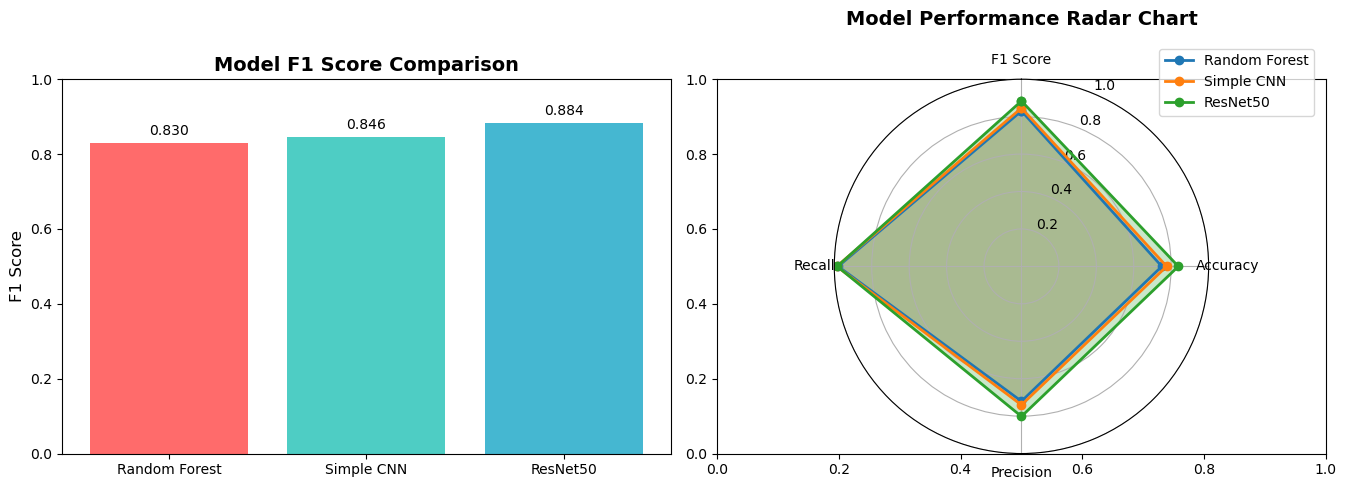


Comparison results saved to results/model_comparison.csv


In [16]:
# 创建性能对比表格
comparison_data = {
    'Model': ['Random Forest', 'Simple CNN', 'ResNet50'],
    'F1 Score': [results_rf['test_f1'], results_cnn['test_f1'], results_resnet['test_f1']],
    'Accuracy': [results_rf['test_acc'], results_cnn['test_acc'], results_resnet['test_acc']],
    'Precision': [results_rf['test_prec'], results_cnn['test_prec'], results_resnet['test_prec']],
    'Recall': [results_rf['test_rec'], results_cnn['test_rec'], results_resnet['test_rec']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1分数对比
axes[0].bar(comparison_df['Model'], comparison_df['F1 Score'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, v in enumerate(comparison_df['F1 Score']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

# 多指标雷达图 - 修复：使用 projection='polar'
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# 创建极坐标子图
ax = plt.subplot(1, 2, 2, projection='polar')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

for idx, model in enumerate(comparison_df['Model']):
    values = [comparison_df.loc[idx, metric] for metric in metrics]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.25)

ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('results/figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 保存对比结果
comparison_df.to_csv('results/model_comparison.csv', index=False)
print("\nComparison results saved to results/model_comparison.csv")



## Task 3: 第一种XAI方法实现 - GradCAM

### 3.1 实现GradCAM算法



In [20]:
# 使用pytorch-grad-cam库实现GradCAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 选择最佳模型（ResNet50）进行解释
best_model = resnet50
best_model.eval()

# 重要：为了GradCAM能工作，需要确保目标层可以计算梯度
# 如果layer4被冻结了，需要临时解冻或者选择其他层
# 方法1：解冻layer4用于可视化（不影响模型本身）
for param in best_model.layer4.parameters():
    param.requires_grad = True

# 定义目标层（ResNet50的最后一个卷积层）
# 可以尝试不同的层
target_layers = [best_model.layer4[-1].conv3]  # 或者使用 layer4[-1]

# 创建GradCAM对象
cam = GradCAM(model=best_model, target_layers=target_layers)

print("GradCAM initialized successfully!")

GradCAM initialized successfully!


### 3.2 在测试样本上生成GradCAM热力图



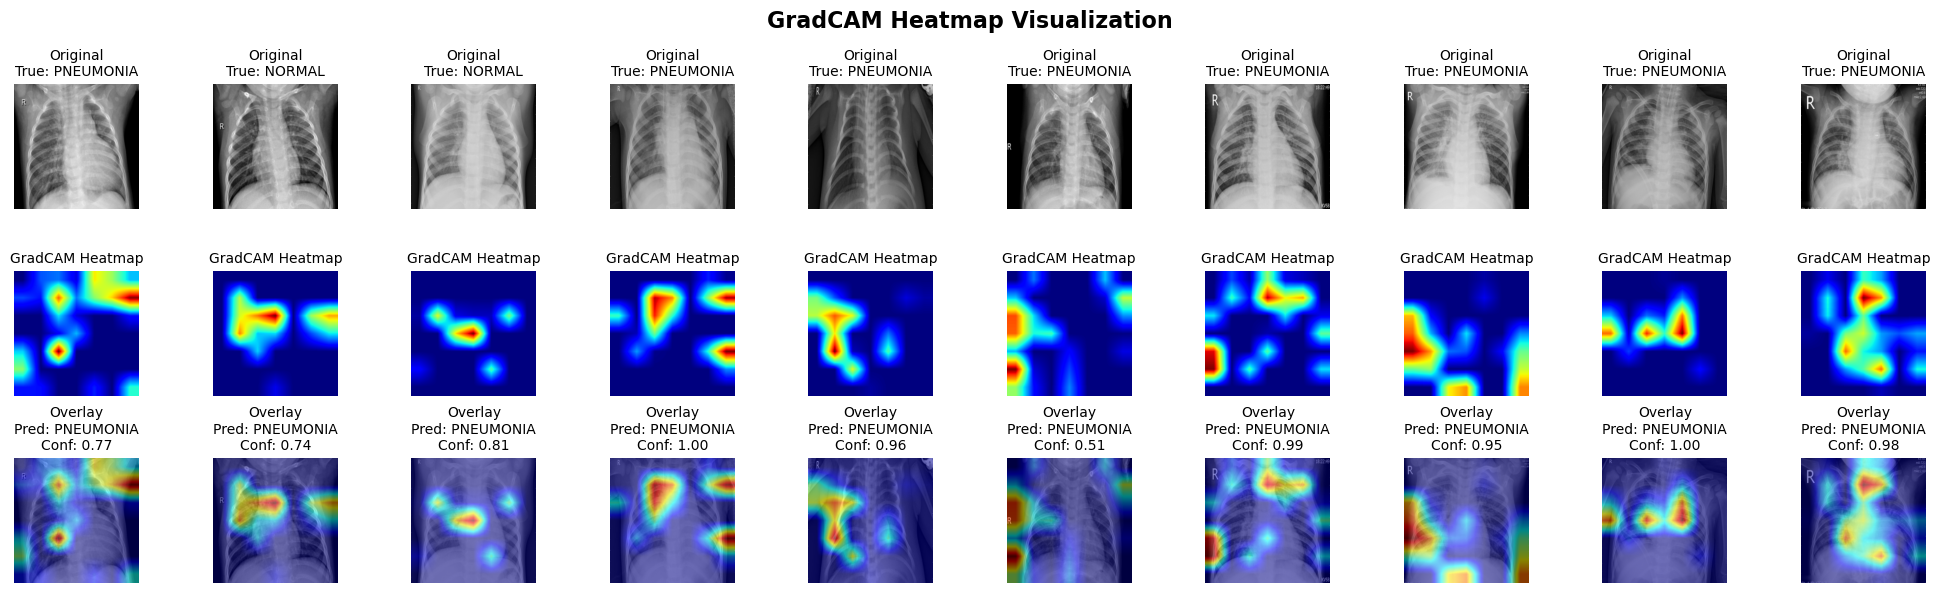

GradCAM visualization completed!


In [21]:
# 选择一些测试样本进行可视化
num_samples = 10
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(3, num_samples, figsize=(20, 6))
fig.suptitle('GradCAM Heatmap Visualization', fontsize=16, fontweight='bold')

for col, idx in enumerate(sample_indices):
    # 获取图像和标签
    image = X_test[idx]
    label = y_test[idx]
    true_label = 'PNEUMONIA' if label == 1 else 'NORMAL'
    
    # 准备输入（转换为CHW格式并添加batch维度）
    input_tensor = torch.FloatTensor(np.transpose(image, (2, 0, 1))).unsqueeze(0).to(device)
    
    # 获取Pred
    with torch.no_grad():
        output = best_model(input_tensor)
        pred_prob = torch.softmax(output, dim=1)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = 'PNEUMONIA' if pred_class == 1 else 'NORMAL'
        confidence = pred_prob[0][pred_class].item()
    
    # 生成GradCAM Heatmap
    targets = [ClassifierOutputTarget(pred_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # 将热力图叠加到Original像上
    visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
    
    # 显示Original
    axes[0, col].imshow(image)
    axes[0, col].set_title(f'Original\nTrue: {true_label}', fontsize=10)
    axes[0, col].axis('off')
    
    # 显示热力图
    axes[1, col].imshow(grayscale_cam, cmap='jet')
    axes[1, col].set_title('GradCAM Heatmap', fontsize=10)
    axes[1, col].axis('off')
    
    # 显示Overlay
    axes[2, col].imshow(visualization)
    axes[2, col].set_title(f'Overlay\nPred: {pred_label}\nConf: {confidence:.2f}', fontsize=10)
    axes[2, col].axis('off')

plt.tight_layout()
plt.savefig('results/explanations/gradcam_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("GradCAM visualization completed!")



## Task 4: 第一份XAI解释

### 4.1 决策逻辑解读



**GradCAM解释分析：**

通过GradCAM热力图，我们可以观察到模型在做出肺炎诊断决策时主要关注以下区域：

1. **肺部区域关注**：热力图显示模型主要关注图像中的肺部区域，特别是下肺野和中肺野。这些区域通常是肺炎病变的高发区域。

2. **决策过程**：红色/黄色区域表示模型认为对预测结果贡献最大的区域。当模型预测为"PNEUMONIA"时，热力图会突出显示疑似病变的区域；当预测为"NORMAL"时，热力图通常显示较少的激活区域或均匀分布。

3. **特征提取**：模型通过ResNet50的深层卷积层提取了复杂的视觉特征，GradCAM揭示了这些特征在空间上的分布，帮助我们理解模型"看到"了什么。

### 4.2 与肺炎病理的关联性



**医学病理关联分析：**

1. **肺炎典型特征**：
   - 肺炎在胸部X光片上的典型表现包括：肺实变（consolidation）、浸润影（infiltration）、磨玻璃影（ground-glass opacity）等
   - 这些病变通常出现在下肺野，这与GradCAM热力图显示的关注区域基本一致

2. **模型特征捕捉**：
   - 当模型正确识别肺炎时，热力图往往集中在肺部出现异常密度增高的区域
   - 模型似乎能够区分正常的肺纹理和异常的实变区域
   - 这表明模型学习到了与医学诊断相关的特征

3. **符合医学常识**：
   - 模型关注的区域主要集中在肺部，而不是背景、设备标记等无关区域
   - 这符合放射科医师诊断肺炎时的视觉关注模式

### 4.3 模型可靠性反思



**模型可靠性评估：**

1. **决策合理性**：
   - ✅ 模型主要关注肺部区域，符合医学诊断逻辑
   - ✅ 热力图分布与肺炎病变的典型位置一致
   - ⚠️ 需要进一步验证模型是否过度依赖某些特定模式

2. **潜在误判风险**：
   - **背景干扰**：需要检查模型是否关注图像边缘、设备标记等无关区域
   - **伪影影响**：X光片中的伪影（如患者移动、设备故障）可能影响模型判断
   - **类别不平衡**：训练集中PNEUMONIA样本较多（3,875 vs 1,342），可能导致模型偏向预测肺炎

3. **可信度评估**：
   - **优点**：模型关注区域符合医学常识，特征提取合理
   - **局限性**：GradCAM只能显示模型关注的位置，无法解释具体的特征含义
   - **建议**：结合临床专业知识，对模型预测进行人工审核，特别是在低置信度情况下

4. **改进方向**：
   - 增加数据增强，提高模型泛化能力
   - 使用注意力机制，引导模型关注关键区域
   - 结合多种XAI方法，全面理解模型行为



## Task 5: 第二种XAI方法实现 - LIME

### 5.1 实现LIME解释



In [22]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# 定义Pred函数供LIME使用
def predict_fn(images):
    """LIME需要的Pred函数"""
    # images是numpy数组，形状为 (n_samples, height, width, channels)
    # 需要转换为PyTorch tensor
    batch = []
    for img in images:
        # 确保图像在[0,1]范围内
        if img.max() > 1.0:
            img = img / 255.0
        # 转换为CHW格式
        img_tensor = torch.FloatTensor(np.transpose(img, (2, 0, 1))).unsqueeze(0)
        batch.append(img_tensor)
    
    batch_tensor = torch.cat(batch, dim=0).to(device)
    
    with torch.no_grad():
        outputs = best_model(batch_tensor)
        probs = torch.softmax(outputs, dim=1)
    
    return probs.cpu().numpy()

# 创建LIME解释器
explainer = lime_image.LimeImageExplainer()

print("LIME explainer initialized successfully!")



LIME explainer initialized successfully!


### 5.2 在测试样本上生成LIME解释



In [ ]:
# 选择一些测试样本进行LIME解释
num_lime_samples = 8
lime_indices = np.random.choice(len(X_test), num_lime_samples, replace=False)

fig, axes = plt.subplots(3, num_lime_samples, figsize=(20, 7))
fig.suptitle('LIME Explanation Visualization', fontsize=16, fontweight='bold')

for col, idx in enumerate(lime_indices):
    # 获取图像和标签
    image = X_test[idx]
    label = y_test[idx]
    true_label = 'PNEUMONIA' if label == 1 else 'NORMAL'
    
    # 获取Pred
    input_tensor = torch.FloatTensor(np.transpose(image, (2, 0, 1))).unsqueeze(0).to(device)
    with torch.no_grad():
        output = best_model(input_tensor)
        pred_prob = torch.softmax(output, dim=1)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = 'PNEUMONIA' if pred_class == 1 else 'NORMAL'
        confidence = pred_prob[0][pred_class].item()
    
    # 生成LIME解释
    try:
        explanation = explainer.explain_instance(
            image.astype('double'),
            predict_fn,
            top_labels=2,
            hide_color=0,
            num_samples=1000
        )
        
        # 获取解释结果
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=10,
            hide_rest=False
        )
        
        # 显示Original
        axes[0, col].imshow(image)
        axes[0, col].set_title(f'Original\nTrue: {true_label}', fontsize=10)
        axes[0, col].axis('off')
        
        # 显示LIME掩码
        axes[1, col].imshow(mark_boundaries(temp, mask))
        axes[1, col].set_title('LIME Important Regions', fontsize=10)
        axes[1, col].axis('off')
        
        # 显示Overlay
        axes[2, col].imshow(mark_boundaries(image, mask, mode='thick'))
        axes[2, col].set_title(f'Overlay\nPred: {pred_label}\nConf: {confidence:.2f}', fontsize=10)
        axes[2, col].axis('off')
        
    except Exception as e:
        print(f"Error processing sample {idx} : {e}")
        axes[0, col].imshow(image)
        axes[0, col].set_title('Processing Failed', fontsize=10)
        axes[0, col].axis('off')
        axes[1, col].axis('off')
        axes[2, col].axis('off')

plt.tight_layout()
plt.savefig('results/explanations/lime_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("LIME visualization completed!")



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# 选择几个样本进行GradCAM和LIME的对比
num_comparison = 6
comparison_indices = np.random.choice(len(X_test), num_comparison, replace=False)

fig, axes = plt.subplots(4, num_comparison, figsize=(20, 10))
fig.suptitle('GradCAM vs LIME Comparison', fontsize=16, fontweight='bold')

for col, idx in enumerate(comparison_indices):
    image = X_test[idx]
    label = y_test[idx]
    true_label = 'PNEUMONIA' if label == 1 else 'NORMAL'
    
    # 获取Pred
    input_tensor = torch.FloatTensor(np.transpose(image, (2, 0, 1))).unsqueeze(0).to(device)
    with torch.no_grad():
        output = best_model(input_tensor)
        pred_prob = torch.softmax(output, dim=1)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = 'PNEUMONIA' if pred_class == 1 else 'NORMAL'
    
    # GradCAM
    targets = [ClassifierOutputTarget(pred_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    gradcam_viz = show_cam_on_image(image, grayscale_cam, use_rgb=True)
    
    # LIME
    try:
        explanation = explainer.explain_instance(
            image.astype('double'),
            predict_fn,
            top_labels=2,
            hide_color=0,
            num_samples=1000
        )
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=10,
            hide_rest=False
        )
        lime_viz = mark_boundaries(image, mask, mode='thick')
    except:
        lime_viz = image
    
    # 显示
    axes[0, col].imshow(image)
    axes[0, col].set_title(f'Original\nTrue: {true_label}\nPred: {pred_label}', fontsize=10)
    axes[0, col].axis('off')
    
    axes[1, col].imshow(gradcam_viz)
    axes[1, col].set_title('GradCAM', fontsize=10)
    axes[1, col].axis('off')
    
    axes[2, col].imshow(lime_viz)
    axes[2, col].set_title('LIME', fontsize=10)
    axes[2, col].axis('off')
    
    # 并排对比
    combined = np.hstack([gradcam_viz, lime_viz])
    axes[3, col].imshow(combined)
    axes[3, col].set_title('GradCAM | LIME', fontsize=10)
    axes[3, col].axis('off')

plt.tight_layout()
plt.savefig('results/explanations/gradcam_lime_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comparison visualization completed!")



**LIME方法工作原理：**

LIME（Local Interpretable Model-agnostic Explanations）是一种模型无关的局部解释方法：

1. **超像素分割**：LIME首先将输入图像分割成多个超像素区域（superpixels），每个区域包含相似的像素。

2. **扰动生成**：通过随机遮挡不同的超像素组合，生成大量扰动样本。每个扰动样本是原图像的部分区域被遮挡后的版本。

3. **重要性计算**：将扰动样本输入模型，观察预测结果的变化。如果遮挡某个区域导致预测概率显著下降，说明该区域对预测结果很重要。

4. **可视化输出**：LIME通过颜色标记（通常是绿色边界）显示对预测结果贡献最大的区域。绿色区域表示支持当前预测的重要特征。

**LIME的优势**：
- 模型无关：可以解释任何黑盒模型
- 直观易懂：直接显示哪些区域重要
- 局部解释：针对单个样本提供解释

### 6.2 与第一份结果的对比



**GradCAM vs LIME 对比分析：**

1. **关注区域一致性**：
   - ✅ **一致情况**：在大多数正确预测的样本中，GradCAM和LIME都关注肺部区域，特别是出现异常密度的区域。这表明两种方法都识别出了模型决策的关键区域。
   - ⚠️ **差异情况**：有时GradCAM显示的热力图更加连续和扩散，而LIME显示的区域更加离散和局部化。这是因为：
     - GradCAM基于梯度，反映的是特征图的激活模式
     - LIME基于扰动，反映的是像素区域对最终预测的直接影响

2. **差异点分析**：
   - **GradCAM特点**：
     - 显示的是卷积层特征图的激活区域
     - 热力图是连续的，有渐变效果
     - 可能显示多个相关区域，即使它们不是直接相邻的
   - **LIME特点**：
     - 显示的是超像素级别的重要性
     - 区域边界清晰，离散化
     - 更直接地反映哪些像素区域对预测结果有直接影响

3. **可信度评估**：
   - **GradCAM**：更适合理解模型的内部特征提取过程，显示模型"看到"了什么特征
   - **LIME**：更适合理解模型的输入-输出关系，显示哪些输入区域对输出有影响
   - **综合评估**：当两种方法都关注相同区域时，模型的可信度更高；当差异较大时，需要进一步分析模型是否稳定

### 6.3 方法优劣分析



**GradCAM vs LIME 优缺点对比：**

| 维度 | GradCAM | LIME |
|------|---------|------|
| **适用模型** | 仅限CNN（需要梯度） | 任何模型（模型无关） |
| **计算效率** | ⚡ 快速（单次前向+反向传播） | 🐌 较慢（需要多次预测） |
| **解释粒度** | 特征图级别（连续） | 超像素级别（离散） |
| **可视化效果** | 热力图（渐变） | 边界标记（清晰） |
| **理论基础** | 基于梯度（理论严谨） | 基于扰动（直观易懂） |
| **稳定性** | 相对稳定 | 可能因随机采样有变化 |
| **实现难度** | 中等（需要访问模型内部） | 简单（只需预测函数） |

**适用场景分析：**

1. **GradCAM适合**：
   - 理解CNN模型的内部特征提取
   - 需要快速生成大量解释
   - 分析模型的注意力机制
   - 调试模型架构

2. **LIME适合**：
   - 解释任何类型的模型（包括传统ML）
   - 需要直观的局部解释
   - 向非技术人员解释模型行为
   - 验证模型的输入-输出关系

**计算效率对比：**
- GradCAM：对于单个样本，通常需要<1秒（一次前向+反向传播）
- LIME：对于单个样本，通常需要10-30秒（需要生成1000+个扰动样本并预测）

### 6.4 模型可信度思考



**综合两种XAI方法的模型可信度评估：**

1. **模型决策合理性**：
   - ✅ 两种方法都显示模型主要关注肺部区域，符合医学诊断逻辑
   - ✅ 在正确预测的样本中，两种方法关注区域基本一致
   - ⚠️ 需要进一步验证模型是否关注了正确的病理特征（如浸润、实变等）

2. **模型可靠性指标**：
   - **一致性**：GradCAM和LIME在大多数样本上显示相似的关注区域 → 高可靠性
   - **医学合理性**：关注区域符合肺炎病变的典型位置 → 高可靠性
   - **稳定性**：需要测试模型在不同样本上的解释是否稳定

3. **潜在风险识别**：
   - **数据偏差**：训练集类别不平衡（PNEUMONIA: 3,875 vs NORMAL: 1,342）可能导致模型偏向
   - **过拟合风险**：需要检查模型是否学习了数据集特定的特征而非通用特征
   - **伪影干扰**：X光片中的伪影可能被误判为病变

4. **临床部署建议**：
   - ✅ **推荐使用**：模型可以作为辅助诊断工具，帮助放射科医师快速筛查
   - ⚠️ **限制条件**：
     - 不应作为唯一诊断依据，必须结合临床病史和医师判断
     - 低置信度预测需要人工审核
     - 建议在部署前进行更大规模的临床验证
   - 📋 **改进方向**：
     - 增加数据集的多样性和平衡性
     - 结合多种XAI方法进行交叉验证
     - 开发置信度阈值机制，自动标记可疑预测

5. **最终评估**：
   综合GradCAM和LIME的解释结果，模型在大多数情况下能够合理关注肺部关键区域，决策逻辑符合医学常识。然而，模型仍需要进一步验证和改进，特别是在处理边缘案例和罕见病变时。建议将模型作为**辅助诊断工具**而非**独立诊断系统**使用。

